In [1]:
import numpy as np
from matplotlib import pyplot as plt

from os import listdir
from os.path import join
from scipy.io import wavfile

import sys
import math

import librosa
import librosa.display

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split


import IPython.display as ipd


In [2]:
def trim_silence(audio, n_noise_samples=1000, noise_factor=1.0, mean_filter_size=100):
    """ Removes the silence at the beginning and end of the passed audio data
    Fits noise based on the last n_noise_samples samples in the period
    Finds where the mean-filtered magnitude > noise
    :param audio: numpy array of audio
    :return: a trimmed numpy array
    """
    start = 0
    end = len(audio)-1

    mag = abs(audio)

    noise_sample_period = mag[end-n_noise_samples:end]
    noise_threshold = noise_sample_period.max()*noise_factor

    mag_mean = np.convolve(mag, [1/float(mean_filter_size)]*mean_filter_size, 'same')

    # find onset
    for idx, point in enumerate(mag_mean):
        if point > noise_threshold:
            start = idx
            break

    # Reverse the array for trimming the end
    for idx, point in enumerate(mag_mean[::-1]):
        if point > noise_threshold:
            end = len(audio) - idx
            break

    return audio[start:end]

In [3]:
def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

In [4]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([max_size] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [5]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


In [6]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.1f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [7]:
def get_white_noise(signal,SNR) :
    RMS_s=math.sqrt(np.mean(signal.astype(np.int32)**2))
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

In [8]:
def add_noise(data):
    
    newdata = []
    for audio in data:
        noise = get_white_noise(audio, 2)
        newdata.append(audio + noise)
    
    return newdata

In [9]:
def change_pitch(data):
    
    newdata = []
    for audio in data:
        newdata.append(librosa.effects.pitch_shift(audio.astype(np.float64), 8000, 2))
    
    return newdata

In [10]:
def data_augmentation(X, y, noise=False, pitch=False, time_shift=False):
    totaldata = X
    if noise:
        totaldata += add_noise(totaldata) 
        y += list(y)
    
    if pitch:
        totaldata += change_pitch(totaldata)
        y += list(y)
        
    return totaldata, y

In [11]:
files = 'recordings/'
ds_files = listdir(files)

X = []
y = []

s = []

for file in ds_files:
    label = int(file.split("_")[0])
    rate, data = wavfile.read(join(files, file))
    trimmed_data = trim_silence(data.astype(np.float16))
    X.append(trimmed_data)
    y.append(label)
    
    s.append(trimmed_data.shape[0])
    

max_size = np.max(s)

print(max_size)

# pad
X = [ np.pad(x, (0, max_size - x.shape[0])) for x in X ]




(4013,)
(4161,)
(2507,)
(3397,)
(1722,)
(3806,)
(3118,)
(3184,)
(4623,)
(4038,)
(4120,)
(2333,)
(3048,)
(3536,)
(2054,)
(1547,)
(2818,)
(3064,)
(3829,)
(2652,)
(2770,)
(3072,)
(2830,)
(2655,)
(2345,)
(2407,)
(4695,)
(3982,)
(2749,)
(3569,)
(4942,)
(2994,)
(2583,)
(1788,)
(4057,)
(5405,)
(2849,)
(2308,)
(2342,)
(2380,)
(3143,)
(3742,)
(4881,)
(2590,)
(3094,)
(3490,)
(1381,)
(2907,)
(3286,)
(2813,)
(2059,)
(3385,)
(2226,)
(2947,)
(4108,)
(1830,)
(2104,)
(2214,)
(2023,)
(2105,)
(3287,)
(4499,)
(3192,)
(4931,)
(3680,)
(2981,)
(4450,)
(3963,)
(2743,)
(2290,)
(3078,)
(3158,)
(3213,)
(2949,)
(1359,)
(3423,)
(4424,)
(3311,)
(4644,)
(3849,)
(2884,)
(2643,)
(3839,)
(3681,)
(3167,)
(2020,)
(7807,)
(3876,)
(2119,)
(4727,)
(4316,)
(2868,)
(2869,)
(4008,)
(2775,)
(2756,)
(3678,)
(4003,)
(2817,)
(4064,)
(2628,)
(3193,)
(4830,)
(3818,)
(4266,)
(3461,)
(3322,)
(2239,)
(2330,)
(2862,)
(1987,)
(3031,)
(5040,)
(3278,)
(2983,)
(3197,)
(2979,)
(2700,)
(3664,)
(2795,)
(3841,)
(3361,)
(2786,)
(2634,)
(3839,)


(3495,)
(4445,)
(3763,)
(3821,)
(4105,)
(3668,)
(2329,)
(2746,)
(3854,)
(2698,)
(4048,)
(2883,)
(4300,)
(3764,)
(4229,)
(3692,)
(3412,)
(2349,)
(3670,)
(1634,)
(3746,)
(3195,)
(5960,)
(2951,)
(3822,)
(2716,)
(3537,)
(2929,)
(3131,)
(3580,)
(4143,)
(4766,)
(2986,)
(2905,)
(2121,)
(3902,)
(4830,)
(3479,)
(3543,)
(3022,)
(4488,)
(4153,)
(4296,)
(2875,)
(2990,)
(4543,)
(3528,)
(4100,)
(3468,)
(3022,)
(3414,)
(3951,)
(2201,)
(3202,)
(5457,)
(3096,)
(3326,)
(3430,)
(3559,)
(3483,)
(5328,)
(2838,)
(2966,)
(5394,)
(4914,)
(6381,)
(3045,)
(2942,)
(4895,)
(4299,)
(3816,)
(5207,)
(3634,)
(3599,)
(3465,)
(6978,)
(2357,)
(4243,)
(3536,)
(3306,)
(3398,)
(4252,)
(3020,)
(3624,)
(2489,)
(2427,)
(3754,)
(3050,)
(3424,)
(2716,)
(4746,)
(2951,)
(4133,)
(4720,)
(4423,)
(4016,)
(5259,)
(3522,)
(5470,)
(5131,)
(3488,)
(1919,)
(2590,)
(1502,)
(2622,)
(2397,)
(3868,)
(3132,)
(2335,)
(2739,)
(3349,)
(4286,)
(3014,)
(2922,)
(2158,)
(3598,)
(2835,)
(1873,)
(2326,)
(4572,)
(2872,)
(2733,)
(4812,)
(3585,)
(17567,)

(4602,)
(2276,)
(2214,)
(3977,)
(2153,)
(2793,)
(4260,)
(2267,)
(3424,)
(3423,)
(3236,)
(2941,)
(1896,)
(4522,)
(3295,)
(2684,)
(3814,)
(3203,)
(2673,)
(3388,)
(5015,)
(4189,)
(2257,)
(3169,)
(2657,)
(2732,)
(4449,)
(5278,)
(3104,)
(4350,)
(2606,)
(3739,)
(2770,)
(2711,)
(2565,)
(1850,)
(3546,)
(3236,)
(2302,)
(4719,)
(3681,)
(3261,)
(1609,)
(3290,)
(4101,)
(2511,)
(2577,)
(1664,)
(2757,)
(4337,)
(3091,)
(4261,)
(1714,)
(3914,)
(4921,)
(2677,)
(1516,)
(3041,)
(3495,)
(3559,)
(3319,)
(2441,)
(7999,)
(4156,)
(2677,)
(2936,)
(2922,)
(4254,)
(2624,)
(6567,)
(3531,)
(4186,)
(2222,)
(3345,)
(3270,)
(1858,)
(4016,)
(3537,)
(3555,)
(3336,)
(2466,)
(4895,)
(3087,)
(3430,)
(2589,)
(3930,)
(2517,)
(2544,)
(6370,)
(3505,)
(3796,)
(2663,)
(2787,)
(2973,)
(3817,)
(3691,)
(4249,)
(2355,)
(3957,)
(2876,)
(2237,)
(4222,)
(5131,)
(4319,)
(4225,)
(4086,)
(3904,)
(3293,)
(2791,)
(2139,)
(3861,)
(4838,)
(3411,)
(2636,)
(2545,)
(3000,)
(2481,)
(4397,)
(4243,)
(4650,)
(2498,)
(3593,)
(3981,)
(5053,)
(4419,)


In [12]:
X, y = data_augmentation(X,y,noise=True, pitch=True)

<class 'numpy.ndarray'>
(7998,)
[-2096. -2772. -2746. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[ 217.  128. -119. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[1182.  485. -457. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ -27. -119.  -87. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[   0. -256.    0. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[1267. 1132.  952. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-94. -52. -21. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[512. 512. 768. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-239. -146.   59. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[1142.  833.  495. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-11.   6.   6. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[2304.  768.    0. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[3204. 2740. 1513. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 9. 20. 26. ...  

<class 'numpy.ndarray'>
(7998,)
[ -8. -24. -43. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[  6.   5. -22. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-119.  -39.   44. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-2868. -2062. -1030. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[18.  6. 11. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[   0. -256.    0. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-14. -18. -22. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[2. 3. 1. ... 0. 0. 0.]
<class 'numpy.ndarray'>
(7998,)
[9. 3. 9. ... 0. 0. 0.]
<class 'numpy.ndarray'>
(7998,)
[118. 511.  81. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-332. -241. -312. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[4. 8. 0. ... 0. 0. 0.]
<class 'numpy.ndarray'>
(7998,)
[5904. 6200. 5776. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-43.  60.  39. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[   0. -256.    0. ...

<class 'numpy.ndarray'>
(7998,)
[ -591. -2086. -3142. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-4596. -4066. -2960. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[88. 47. -4. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[286. 236. 189. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-256.    0. -256. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-6996. -6264. -6440. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-7. -7.  1. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[-7170. -6910. -4864. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-75. -33. -45. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ 374. -539. -526. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-1574.     5.  1407. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[1. 2. 3. ... 0. 0. 0.]
<class 'numpy.ndarray'>
(7998,)
[   0.    0. -256. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-1280.    70.  -123. ...     

<class 'numpy.ndarray'>
(7998,)
[ 256.  512. 1280. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-10.   2.  -8. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[  512.  -256. -1024. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-192. -486. -497. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-7424. -9470. -9980. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[270. 413. 644. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-573. -502. -188. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-17. -52.  43. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[1432. 3204. 2136. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-256. -512.    0. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ -7.   5. -31. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ 133. -344. -756. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-1565.   598.  1397. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[ 29. -64. 1

<class 'numpy.ndarray'>
(7998,)
[-3196.  -774.   929. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-19. -20.  -8. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[   0. -256. -256. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-2260.  -563.  -200. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[212. 281. 301. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-834. -945. -510. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[378. 555. 892. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[  94. -311. -111. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[  1. -17. -27. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ 750. 1112. 1251. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-15.  -1.  -8. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[1024. 1024. -256. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[127. 106.  49. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ 594. 1143. 1199. ...    0.  

<class 'numpy.ndarray'>
(7998,)
[ -211. -1189. -1528. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-23. -15. -10. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[5836. 6868. 6216. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 304. -265.  101. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[24. 20. 25. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[ 811. 1011. 1210. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[1644. 1462. -465. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 949.  397. -639. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-256.    0.    0. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-2048. -2048. -1536. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-100. -945. -450. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[  57. -165.  228. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-54. 127.  44. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ 5096.  1928. -16

<class 'numpy.ndarray'>
(7998,)
[116.  -1. -49. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ -62. -127. -117. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 1572. -1748.  -624. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-885. -523. -601. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-304. -319. -377. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[835. 704. -48. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ -921. -1792. -1289. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-335. -163. -532. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 119.  681. 1117. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-129.   84.  221. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 118. -113. -236. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[3224. 2352.  598. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ -768. -1280. -1280. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)


<class 'numpy.ndarray'>
(7998,)
[-1390.  -992.  -296. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[665. 468. 203. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-58.   5. -71. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[352. 250. 196. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-5376. -5120. -4350. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-418. -537. -725. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-3768. -3320. -4000. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[3902. 4062. 3532. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 6868. -2948. -6370. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-4700. -5040. -4350. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[ -74. -202.  -60. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-1314. -2396. -3156. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[ 478.   21. -133. ...    0.    0.    0.]
<class 'numpy.ndarra

<class 'numpy.ndarray'>
(7998,)
[-2304. -1105.    84. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[193. 305. 356. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-2. -3. -6. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[ 845.  334. -101. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ -37. -536. -250. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-39. -11.   9. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-30. -41. -49. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-2732. -2924. -2820. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-875. 4984. 9176. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[16.  8. 23. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[-512.  256.  256. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[1189. 1064.  788. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-256. -256. -512. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-3432.  -543. -2248. ...     0.    

<class 'numpy.ndarray'>
(7998,)
[357. 225. -93. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[0. 0. 0. ... 0. 0. 0.]
<class 'numpy.ndarray'>
(7998,)
[27.  9. -4. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[-256. -512. -256. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-2900. -7724. -6510. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-2504.   728.  4020. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-640. -820. -990. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-256. -256.    0. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-41.  -1. -51. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ -45. -250.  200. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-4276. -3088. -1589. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[2047. 3024. 4276. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 1. -4. -7. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[-512.    0. -256. ...    0.    0.    0.]


<class 'numpy.ndarray'>
(7998,)
[-1278. -3220. -4148. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-256. -256. -256. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[162. 541. 773. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-9220. -9470. -7936. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-573.  199. -159. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-5000. -2510.  -682. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[ 6936.  -892. -5612. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[ 564.  934. 1331. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-134. 2052. 1939. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-285. -294. -222. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[147. 139. 192. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-44.  56. 106. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ 728.  449. -795. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)


<class 'numpy.ndarray'>
(7998,)
[0. 0. 0. ... 0. 0. 0.]
<class 'numpy.ndarray'>
(7998,)
[-298. -318. -286. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-256. -512. -256. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-3172. -4548. -4424. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-12.  22. -20. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-2068. -1633. -9740. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[ -50. -176.  522. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 3574. -1420. -2015. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[   0. -256. -256. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-11.  36. -28. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ 0. -3.  1. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[1280. 1792. 2816. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[2824. 2976. 2650. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-125.  221.  574. ...    0.  

<class 'numpy.ndarray'>
(7998,)
[1. 2. 1. ... 0. 0. 0.]
<class 'numpy.ndarray'>
(7998,)
[  368.  -698. -1474. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[ -8.  -7. -14. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[129. 643. 606. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-256. -256. -768. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-37. 107. 313. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ 8.  3. -5. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[-1637. -3126. -6892. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-159. -122.  -69. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-1523. -2248. -2202. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[ 424.  562. 1036. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[5. 4. 2. ... 0. 0. 0.]
<class 'numpy.ndarray'>
(7998,)
[-3384. -4100. -3492. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[1280. 2048. 1280. ...    0.    0.    0.]
<class

<class 'numpy.ndarray'>
(7998,)
[1081. 1435. 1450. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 1119.   947. -2412. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[  0. -12.  -4. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[3764. 6216. 6530. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[1884. 2035. 2112. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-3.  2. -2. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[-316. -307. -399. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 26.  28. -50. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ -15. -189. -392. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-705. -653. -451. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[1679.  912.  446. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-16.   4.   6. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[333.  31. 208. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[2668. 6244. 8260. ...    0.    0.  

<class 'numpy.ndarray'>
(7998,)
[-12.   8.   6. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ 4. -5. -7. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[-29. -21. -16. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ 1232.  -694. -1620. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-341.  845. 1750. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-354. -132. -135. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-256. -256.    0. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-973.  153. 1837. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 755.  -50. -272. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ -4. -39.  20. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[3000. 2126. 3404. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-1969. -2364. -2954. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-152. -268. -567. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 263. -249.  258. ...  

<class 'numpy.ndarray'>
(7998,)
[ -8. -14.  22. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-240.  852. 1681. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-97. -28. -42. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-763.   70.  454. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[2338.  738. -104. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-1461.   784.    57. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[ 7.  1. -2. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[-256. -256. -256. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[949. 701. 557. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[2304. 3072. 4350. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 1121.  1771. -1046. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[219. 276. 424. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-1252.  -740.  -677. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-2. -3.  3. ...  0.  0.

<class 'numpy.ndarray'>
(7998,)
[-1704. -2396.    26. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[   0. -512. -768. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-110.  -13. -196. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-166. -220. -133. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[534. 587. 365. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ 6.  8. 11. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[  59. -210.   56. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[1024. 1280. 2048. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-512. -512. -512. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 729.  266. -179. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[256.   0. 256. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-434. -392. -925. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ -209. -2956. -4876. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-256. -256. -512.

<class 'numpy.ndarray'>
(7998,)
[ 1921. -1205. -7936. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-2. -6.  0. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[4270. 3624. 2022. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 21.  19. -41. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[21. 19. 18. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[-485.  -44. -859. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-142. -311. -283. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-1901. -2498. -1511. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-1232. -1534. -1465. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[612. 239. 201. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-18. -19. -18. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-256.    0. -256. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[17. -5.  7. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[-48. -69. -65. ...   0.   0.   0.]
<class

<class 'numpy.ndarray'>
(7998,)
[-1397. -1396. -1087. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[ 9. 39.  6. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[122. 168. 292. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[1024. 1024.  512. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-11. -16. -28. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-2. -4. -2. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[ 118.  809. 1291. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[4864. 6144. 6144. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[631. 436. 617. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ -61. -196.  182. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[0. 0. 0. ... 0. 0. 0.]
<class 'numpy.ndarray'>
(7998,)
[-1206. -1299. -1117. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[124. 163. 183. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-15.  15.  11. ...   0.   0.   0.]
<class 'numpy.ndarray'>


<class 'numpy.ndarray'>
(7998,)
[434. 222.  57. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[2592. 2030. 1192. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[5. 5. 1. ... 0. 0. 0.]
<class 'numpy.ndarray'>
(7998,)
[2154.  928. -184. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-329. -391. -465. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-6144. -6400. -6144. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[0. 0. 0. ... 0. 0. 0.]
<class 'numpy.ndarray'>
(7998,)
[-256. -256. -256. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-1680. -5196. -4520. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-1206. -1872.  -947. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-4790. -3270.  4570. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-284. -526. -638. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-66. -15.  54. ... 148. 292. 351.]
<class 'numpy.ndarray'>
(7998,)
[-4212. -2884. -1315. ...     

<class 'numpy.ndarray'>
(7998,)
[-256.    0. -512. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-35.  25. -57. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-5630. -5890. -5630. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[687. 665. 666. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[  326. -1589. -2870. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-594.  295.    2. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 623.  942. 1011. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[4350. 3072.  512. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ -810.  -998. -1141. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[ 960. 1283. 1247. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 1. 26. 33. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[-4976. -3708. -2856. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-8670. -8190. -6180. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)


<class 'numpy.ndarray'>
(7998,)
[-690. -209.  365. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-2072. -2452. -2540. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[ -97. -278. -380. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-256.    0. -256. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[2692. 1747. 1302. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[30. 59. 75. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[-338.   86. -179. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[264. 113. 336. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-1. -1. -2. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[-4100.   373.  -541. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-3900. -3216. -2180. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[198. 248. 312. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[512. 512. 512. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[782. 729. 931. ...   0.   0. 

<class 'numpy.ndarray'>
(7998,)
[-182. -172. -128. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-2736.  5524.   684. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[ 20. -49.  38. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[  3.  -5. -10. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[498. 551. 400. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-720. -545. -517. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-2. -3.  0. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[  9.  -4. -10. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-256.    0.    0. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-100.  106.  187. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-28. -10.  -8. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[2816. 2304. 1280. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 755. 1013. 1274. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[   81.  -888. -1404. ...     0.     0.   

<class 'numpy.ndarray'>
(7998,)
[-24. -28. -23. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ 740. 3952. 5624. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[   0.    0. -256. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-3.  0. -4. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[ -31.  -88. -181. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-1027.  -772.  2384. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-308. -140.  -94. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-2035. -3408. -4018. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-1666. -1236.  -712. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[-23.  18.  12. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[1888. 1853. 1636. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 19. -30.  21. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[2912. 1789.  366. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-933. -840. -760.

<class 'numpy.ndarray'>
(7998,)
[-512. -256. -512. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-1533. -6756. -9100. ...     0.     0.     0.]
<class 'numpy.ndarray'>
(7998,)
[   0.    0. -512. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[  75. -117. -253. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[578. 531. 516. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[21. 22. 18. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[ 3. 12.  6. ...  0.  0.  0.]
<class 'numpy.ndarray'>
(7998,)
[-224.  203. -763. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-256. -256.    0. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[ 19. 271.  74. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[-27.  -2. -18. ...   0.   0.   0.]
<class 'numpy.ndarray'>
(7998,)
[ 394.   84. -289. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[3632. 3464. 3156. ...    0.    0.    0.]
<class 'numpy.ndarray'>
(7998,)
[-118.  -61. -108. ...    0.    0.    0.]


<class 'numpy.ndarray'>
(7998,)
[-254.92687705 -195.44844293  -27.38053502 ...  -74.23209225  150.96046856
 -286.84470647]
<class 'numpy.ndarray'>
(7998,)
[-9.11206572e+02 -1.98682471e+03  3.65607105e+02 ...  2.76373024e+03
 -1.29422934e+00  1.67542213e+03]
<class 'numpy.ndarray'>
(7998,)
[  77.52839368 -183.90926774 -285.68804215 ...  -35.58686011   81.76445467
   18.21427534]
<class 'numpy.ndarray'>
(7998,)
[ 156.23601718  266.04506654 -413.79419679 ... -611.4030158   222.87692927
  281.876219  ]
<class 'numpy.ndarray'>
(7998,)
[  270.39586773   878.32582794 -1141.32184028 ...  1875.51854748
  1503.64016358 -1898.12978987]
<class 'numpy.ndarray'>
(7998,)
[-4598.00888611 -3864.43501308 -6673.63119733 ...  -404.19147884
 -1063.77134183  -475.63134899]
<class 'numpy.ndarray'>
(7998,)
[-172.7561769   194.18240382  478.55247634 ...  401.43569955  253.61230774
 -248.19854753]
<class 'numpy.ndarray'>
(7998,)
[2415.45973028 2484.17503784 1547.19749923 ...  173.51519282 -118.86530345
 -144.34

<class 'numpy.ndarray'>
(7998,)
[-3645.64409646 -2417.09456394   533.65451186 ... -2866.58096849
  -856.40247734  2094.95955002]
<class 'numpy.ndarray'>
(7998,)
[2109.27009559  789.99089975 -245.36027621 ... -903.40078012  662.29085499
  -99.68904739]
<class 'numpy.ndarray'>
(7998,)
[  935.10359362 -1787.7853577    964.97530324 ...   198.6768728
 -1199.64831363  -293.92788252]
<class 'numpy.ndarray'>
(7998,)
[-121.0800982   -49.98354982   89.5344913  ...   91.28353968  -18.19151322
  158.40850478]
<class 'numpy.ndarray'>
(7998,)
[-211.71777776  121.54591578 -213.60747926 ...   40.89692275 -183.05072644
  -82.02413856]
<class 'numpy.ndarray'>
(7998,)
[  38.13818086   84.82507681   25.35210445 ... -126.82833776  142.41501768
    3.94070929]
<class 'numpy.ndarray'>
(7998,)
[-61.49792872 629.09233983 -83.94787751 ...  48.16816756 139.619274
 153.44941488]
<class 'numpy.ndarray'>
(7998,)
[ 1631.96311563   191.47014547   879.4216636  ...   470.46454668
 -1450.89264077   304.3178814 ]
<class 

<class 'numpy.ndarray'>
(7998,)
[  2.77076489  35.09935864 -15.60260669 ...  21.94469177  72.42022663
 -50.08050169]
<class 'numpy.ndarray'>
(7998,)
[ 2328.44495819 -1837.67684928   -59.61557451 ...  -217.50142777
   570.25705498 -1779.37122121]
<class 'numpy.ndarray'>
(7998,)
[-6.97589969e+02 -5.12998024e+02  1.94748730e+02 ...  6.25055798e-01
  7.47991503e+01  1.62905014e+01]
<class 'numpy.ndarray'>
(7998,)
[-4924.8703124  -2974.12340005 -2808.48268173 ...  -120.20052606
  -903.12366494  -513.27118112]
<class 'numpy.ndarray'>
(7998,)
[-565.57730418 -306.77802392  306.69309402 ... -163.84697869  -66.86062056
  311.8081486 ]
<class 'numpy.ndarray'>
(7998,)
[32.04417667  0.80766667 25.26219    ... 32.01623341 55.25538618
  4.12965725]
<class 'numpy.ndarray'>
(7998,)
[-3271.08214273 -2126.71447066 -2138.41632523 ...   348.22761481
 -1451.71360518   553.56440452]
<class 'numpy.ndarray'>
(7998,)
[1305.90137207 2109.46097592 1819.15230084 ... 1510.475929     -7.93698302
 1685.42331182]
<cla

<class 'numpy.ndarray'>
(7998,)
[-7451.10358299 -5531.80408207 -2331.65268324 ...  -576.76730136
  -825.30662125  -468.73312026]
<class 'numpy.ndarray'>
(7998,)
[ -522.43770597 -1064.9998581  -1361.65454825 ...   160.02850708
    71.0931534    306.03165886]
<class 'numpy.ndarray'>
(7998,)
[-139.45808458 -146.93156403  -45.09010595 ...  -65.75703705  -74.195162
  349.11967232]
<class 'numpy.ndarray'>
(7998,)
[  275.43866034   349.66112818   396.3599908  ...  -510.04583763
   604.66548117 -1162.32800885]
<class 'numpy.ndarray'>
(7998,)
[ 123.85330455  -40.50094207 -303.54287041 ... -170.26812813  281.18683858
   53.3447168 ]
<class 'numpy.ndarray'>
(7998,)
[-1670.01149421  -739.40939482  3525.65517051 ...   396.46618694
  -158.32143174   -23.52248334]
<class 'numpy.ndarray'>
(7998,)
[-1775.63015167 -1854.60107894 -1744.82258551 ... -1027.60397737
   677.04671585  -158.3019391 ]
<class 'numpy.ndarray'>
(7998,)
[ -69.44612888 -155.0185758    96.64167813 ... -223.16416148   40.77641961
  -8

<class 'numpy.ndarray'>
(7998,)
[-262.63254757  395.08355453   76.09875724 ... -778.96054107 2494.91138033
 1417.78849018]
<class 'numpy.ndarray'>
(7998,)
[ -807.66524831  -413.59131885  1116.14072842 ...  -979.14315275
  1048.35199471 -1836.0627632 ]
<class 'numpy.ndarray'>
(7998,)
[ 227.4762974   377.58744509   18.74082491 ...    1.60386193 -160.36258263
 -129.08352479]
<class 'numpy.ndarray'>
(7998,)
[-193.48182269  370.95622104 -683.54559485 ...  582.93708072 -740.81340772
 -971.77296957]
<class 'numpy.ndarray'>
(7998,)
[-50.76172665 -74.07016986 207.95539331 ... -67.111218    67.71558174
 147.5271128 ]
<class 'numpy.ndarray'>
(7998,)
[-203.95174352  393.52438721  752.43924733 ...   23.25981146   83.60966746
 -390.0615564 ]
<class 'numpy.ndarray'>
(7998,)
[-745.69861225  267.94117801  465.06477979 ...  -62.81026603  -27.12804012
  192.53283251]
<class 'numpy.ndarray'>
(7998,)
[ 687.00475395  553.81112326  238.52065668 ... -624.9252391  -786.80617754
 -352.25133988]
<class 'numpy.nd

<class 'numpy.ndarray'>
(7998,)
[-237.7837411  -151.58698329  159.94309245 ...  107.59214727 -105.00470802
   90.0030199 ]
<class 'numpy.ndarray'>
(7998,)
[ 3427.98675097  1701.46294249  4288.47061371 ...  -340.65360533
   262.91563062 -1615.96384642]
<class 'numpy.ndarray'>
(7998,)
[  195.21214548 -2973.0311144  -1598.03282213 ... -1054.39451714
   -45.69837585   -52.33955068]
<class 'numpy.ndarray'>
(7998,)
[-1831.46617831 -1235.87252164 -1268.30090106 ...  -401.45377685
   -70.47036816   433.93431032]
<class 'numpy.ndarray'>
(7998,)
[ 29.33315356 177.62127957 212.78059358 ... 107.41870375 102.64582642
  33.47291302]
<class 'numpy.ndarray'>
(7998,)
[-71.03340718 129.13729149  85.77141957 ... 126.89908322 105.08838078
   2.77600476]
<class 'numpy.ndarray'>
(7998,)
[-1114.7624151   -637.75144765  -816.71649548 ...   -78.81232724
    23.8236661   -447.74521201]
<class 'numpy.ndarray'>
(7998,)
[ 2494.06457831  2174.50370811  1139.50390976 ... -1375.91764083
  -538.13577324  -441.9836587 

<class 'numpy.ndarray'>
(7998,)
[ 1082.51592112 -1944.73958753 -5916.09721116 ...   424.03588034
  -391.26850501   738.14682316]
<class 'numpy.ndarray'>
(7998,)
[ 519.07283036  687.87739101 1360.25786555 ...  180.55153951   27.74370821
    9.74897704]
<class 'numpy.ndarray'>
(7998,)
[-821.4836248  -187.71144917 -531.89426295 ...  285.2405463   787.05345906
 -228.4984225 ]
<class 'numpy.ndarray'>
(7998,)
[-251.59439996 -676.09653196   63.41596039 ... 1691.56227575 1529.7712314
  373.55590827]
<class 'numpy.ndarray'>
(7998,)
[-151.08519941   20.82785899    6.82956404 ... -152.11359872 -253.18650272
 -109.45974763]
<class 'numpy.ndarray'>
(7998,)
[2235.11409654  706.89013552 -686.97126785 ...  -46.05176108  639.94945767
  198.19807024]
<class 'numpy.ndarray'>
(7998,)
[ 417.2344079  -485.03574619  295.45184901 ...   57.67403132  387.41972082
  216.65087799]
<class 'numpy.ndarray'>
(7998,)
[-16.55466223  64.01079388  11.64168078 ...   9.50829052 120.2411805
  -4.44959527]
<class 'numpy.ndar

<class 'numpy.ndarray'>
(7998,)
[ -35.80259534   74.6797601  -247.770871   ...  -80.5482127    60.21632195
 -356.65053883]
<class 'numpy.ndarray'>
(7998,)
[-1049.1535446   1866.99922809  1399.66808336 ...  1265.23289387
 -1308.78051409  -419.780887  ]
<class 'numpy.ndarray'>
(7998,)
[ -483.099597   -4086.5900173    600.16100161 ...   482.8717257
  1039.89618438  1991.99301316]
<class 'numpy.ndarray'>
(7998,)
[ 1527.39257036    88.66839069  1191.42518308 ...  1866.69064555
 -1757.26490729  -382.19444109]
<class 'numpy.ndarray'>
(7998,)
[-107.43131957  -21.64939886 -101.14415967 ... -218.7355623  -272.64115764
 -322.77183791]
<class 'numpy.ndarray'>
(7998,)
[ 2406.41544364   926.26342823 -1157.01596719 ...   -73.80436063
 -1239.72384356 -2316.63092608]
<class 'numpy.ndarray'>
(7998,)
[  42.79256994   39.01886282  -77.7080561  ... -103.18391289 -289.31937528
  228.58584938]
<class 'numpy.ndarray'>
(7998,)
[ -53.3699915  -296.80434393  -68.32454053 ... -119.66994488   96.91393702
  135.225

<class 'numpy.ndarray'>
(7998,)
[-1199.11959353  -197.55119074  -335.01152585 ...  -545.99988337
   574.03710667  -469.29368552]
<class 'numpy.ndarray'>
(7998,)
[ -143.33093377 -1097.83491534  1832.61635826 ...  -508.84784387
    28.21179569   -17.65832429]
<class 'numpy.ndarray'>
(7998,)
[-844.95594261 1056.81706612  818.4803416  ... 1188.12070787 -240.44581363
  -87.08474839]
<class 'numpy.ndarray'>
(7998,)
[ 477.57515418  829.44141103  943.44477774 ...  423.94268464 -279.14813297
 1698.49714737]
<class 'numpy.ndarray'>
(7998,)
[ 37.63031346 -11.62053089  12.59643893 ...  59.45631468  57.43673184
  97.55333687]
<class 'numpy.ndarray'>
(7998,)
[ 545.4091487  -252.17861336  667.05865272 ...  335.83704914   90.40435092
 -209.17589028]
<class 'numpy.ndarray'>
(7998,)
[ 198.50219974  560.93843272  654.03286607 ... -169.75589432 -322.10890414
  -40.62323096]
<class 'numpy.ndarray'>
(7998,)
[102.32375287  46.76402677 142.79427825 ...  74.59582817 -63.76571954
 -11.37882519]
<class 'numpy.nd

<class 'numpy.ndarray'>
(7998,)
[-728.41403846 -776.44144123  229.62308737 ... -584.67255065  233.00420277
  204.49664789]
<class 'numpy.ndarray'>
(7998,)
[  429.52767241   666.78694382   457.91201942 ... -1047.37435045
  1534.75327787  1370.65493063]
<class 'numpy.ndarray'>
(7998,)
[-350.92718615 -261.56733075  -70.63909045 ...    4.85996449   12.11405734
   26.1372345 ]
<class 'numpy.ndarray'>
(7998,)
[-44.96025239   5.37099311 105.43770613 ... 102.91021996  46.34963893
  96.05524831]
<class 'numpy.ndarray'>
(7998,)
[-1357.7631054   -874.54174935 -2086.20305519 ...   354.26463074
    60.45678372   -65.54934918]
<class 'numpy.ndarray'>
(7998,)
[-1560.10402215  -796.14096222  1095.57035028 ...  1071.43746987
 -1672.62741351  -617.45465464]
<class 'numpy.ndarray'>
(7998,)
[1352.85092354 -975.59688991 -625.49142485 ... -279.74139644  613.78362823
 -365.2213145 ]
<class 'numpy.ndarray'>
(7998,)
[-2700.21600773   285.72354679   929.65702185 ...  -675.60466692
  -181.60316932  1362.47934772

<class 'numpy.ndarray'>
(7998,)
[-1552.4357063   -173.19652077  -744.93333445 ...  2417.03395106
 -1123.6769734   -702.33112977]
<class 'numpy.ndarray'>
(7998,)
[-247.08557262  -94.21332195   46.05238141 ...   52.84573302  -54.19417892
  -61.69716712]
<class 'numpy.ndarray'>
(7998,)
[ -63.01605672  -16.73573367   77.95732414 ... -346.46399348 -151.35519617
   45.98505151]
<class 'numpy.ndarray'>
(7998,)
[-212.62323929 -380.00926085  143.10388536 ...  -30.9695256  -146.04727188
 -168.10855396]
<class 'numpy.ndarray'>
(7998,)
[ 2088.42089392  -974.07541035 -1024.98079247 ...   382.9265548
   855.43784168   852.78063097]
<class 'numpy.ndarray'>
(7998,)
[-40.14262533 -73.67273721  61.6155193  ... 244.73243034  49.12036718
 -45.81604771]
<class 'numpy.ndarray'>
(7998,)
[ -728.91551299 -1151.60400942  -144.02289559 ...  1731.26949799
  -790.95579804   652.55832493]
<class 'numpy.ndarray'>
(7998,)
[ -526.50701299 -1408.25880167   912.39472195 ...  -628.88602514
   905.10089488 -1587.58734471]

<class 'numpy.ndarray'>
(7998,)
[ -50.41769286  -21.90877927    7.56149033 ... -110.61593688   14.03995188
  -37.35550489]
<class 'numpy.ndarray'>
(7998,)
[3393.86144133 1116.18628016 -711.49429812 ...  156.80636469 4436.71733973
   30.71909955]
<class 'numpy.ndarray'>
(7998,)
[-854.10259803 -216.59207648 -497.72920013 ...   50.84116637   99.50495753
   -9.09208493]
<class 'numpy.ndarray'>
(7998,)
[ 2022.92828041  1745.87339288  2366.67782485 ...  -497.53196779
  -902.68186692 -2168.66838278]
<class 'numpy.ndarray'>
(7998,)
[ 1548.78380193  1019.22920287   722.78217099 ... -2319.71948779
  1488.48258301  1639.57606861]
<class 'numpy.ndarray'>
(7998,)
[ -10.36328161  553.89495197 1048.96023763 ...   21.67540959 -656.94964781
  370.28001135]
<class 'numpy.ndarray'>
(7998,)
[-75.08817904 155.79988365  -3.19394684 ...  -5.61232391 -61.10653732
  -9.78811213]
<class 'numpy.ndarray'>
(7998,)
[-159.59498438  -29.00420818  183.06397646 ... -150.37074424  -29.41372503
   45.79242068]
<class 'nu

<class 'numpy.ndarray'>
(7998,)
[  611.89070019  -271.680033   -1110.64527353 ...   450.83351764
  2492.03388294   146.16398022]
<class 'numpy.ndarray'>
(7998,)
[-169.42503656  269.48009122  -50.68704613 ...  122.58112751  161.60230974
  122.59453502]
<class 'numpy.ndarray'>
(7998,)
[ -83.54711743   84.79198361 -100.67089351 ...   39.57351411   20.54631695
  108.97947576]
<class 'numpy.ndarray'>
(7998,)
[-3555.73584698 -1927.33537475 -1801.12356639 ...    -6.29808786
  -296.04645383  -871.51579089]
<class 'numpy.ndarray'>
(7998,)
[-1508.7298753   4434.44828026  9398.46917533 ...   125.31629453
   296.61368299  -726.10925645]
<class 'numpy.ndarray'>
(7998,)
[-140.19337155   52.29373234 -168.30076728 ...  169.04171789   54.3902788
  -24.90288018]
<class 'numpy.ndarray'>
(7998,)
[-645.6548899   107.87053734  158.74974033 ... -441.83345462  890.3393829
  218.15719678]
<class 'numpy.ndarray'>
(7998,)
[1305.61891752 1054.22539608  895.84398911 ...   -8.59327609  -16.86669458
   81.19341828]


<class 'numpy.ndarray'>
(7998,)
[-4335.50258197 -3780.01373767 -6007.67245058 ...   360.25049734
  -364.51119817    73.58908714]
<class 'numpy.ndarray'>
(7998,)
[  962.4888896   1612.69042327   433.92497387 ... -2317.92852623
 -1139.75205311   660.62425923]
<class 'numpy.ndarray'>
(7998,)
[ 178.54149202   33.48721232 -331.13276569 ...  -82.99799205 -120.71825423
  142.70064096]
<class 'numpy.ndarray'>
(7998,)
[-3336.03248225 -3149.72935374 -1431.27370754 ...  -763.42061648
   -57.0404155   -938.00899157]
<class 'numpy.ndarray'>
(7998,)
[  424.87025963   -74.82297401 -1760.22641233 ...   165.40449868
  -286.07637464   972.1541062 ]
<class 'numpy.ndarray'>
(7998,)
[-160.33867689 -121.41112188 -110.87612917 ... -134.13809609  -34.7064346
 -116.28602968]
<class 'numpy.ndarray'>
(7998,)
[   81.22875436   362.52890624  2860.64439875 ...   899.53534084
 -2367.83240798   -65.37479335]
<class 'numpy.ndarray'>
(7998,)
[-52.63272164   6.73131758 -29.12221199 ...  63.50740186  10.78550997
  83.386

<class 'numpy.ndarray'>
(7998,)
[4618.69526847 2993.31111824 1912.38385971 ... 1326.88336884 -697.59410795
 -538.54385607]
<class 'numpy.ndarray'>
(7998,)
[  -6.41392399   84.80538601 -144.45154877 ...   65.32247866  -10.90156009
   36.82893759]
<class 'numpy.ndarray'>
(7998,)
[-1181.57359483  -690.59766735 -2483.83174685 ...  -816.76837816
  -865.33820669   551.71601795]
<class 'numpy.ndarray'>
(7998,)
[-1804.20079186 -3845.17776481 -3373.96302697 ... -1523.32229836
   885.51375249   -42.67444881]
<class 'numpy.ndarray'>
(7998,)
[   1.45409949 -121.72120197  -47.89796376 ...  -88.43023757  -81.08193806
   -3.23488643]
<class 'numpy.ndarray'>
(7998,)
[2060.72751716 2742.86068622 2863.09016456 ... -450.92744963 -108.20877903
  527.34904466]
<class 'numpy.ndarray'>
(7998,)
[-3597.22343578 -1150.70501063  -912.0820995  ...   474.79742712
  -113.94249951   196.48449824]
<class 'numpy.ndarray'>
(7998,)
[383.75589943 500.33331431 334.00825983 ... 307.86715905 -16.56018413
 704.95436753]
<cla

<class 'numpy.ndarray'>
(7998,)
[-9430.5766691  -9276.75351347 -8299.23471348 ...  1302.69977822
  2240.82626017  1068.26984127]
<class 'numpy.ndarray'>
(7998,)
[-1874.75797672 -1392.57547053  1610.57251815 ...  1406.76485887
  -313.28866825  -825.36193759]
<class 'numpy.ndarray'>
(7998,)
[-4092.12391708   869.18204931 -2361.81960142 ...  1586.88560815
  3336.09801566 -2000.49006783]
<class 'numpy.ndarray'>
(7998,)
[ 6865.86165224  -658.61042817 -5840.27778525 ... -1030.56703196
  -321.65445854   203.84452624]
<class 'numpy.ndarray'>
(7998,)
[ -33.74812189  221.41522263 2073.29255993 ...  -34.15435278 -121.60748434
  266.33491716]
<class 'numpy.ndarray'>
(7998,)
[-377.50038445  804.58335164 3062.5754348  ... -105.72153206  713.07205519
  531.74716934]
<class 'numpy.ndarray'>
(7998,)
[-276.30335216 -223.39188948 -428.51193845 ...  281.39595927 -147.21524928
    6.80790832]
<class 'numpy.ndarray'>
(7998,)
[ 134.25255258   28.5804339   296.60746353 ... -114.46327389  -44.7918144
  -74.753

<class 'numpy.ndarray'>
(7998,)
[ -15.21320874 -102.5302154  -100.3885461  ...  -33.91461675 -106.31862362
  -56.85898218]
<class 'numpy.ndarray'>
(7998,)
[ 498.5318813   847.29332792 -549.4647616  ... -967.06246433 1762.42831294
  481.66471484]
<class 'numpy.ndarray'>
(7998,)
[-5317.02239924 -3815.37520763 -1947.16837596 ...  -394.03218741
   146.21256277  -374.09157972]
<class 'numpy.ndarray'>
(7998,)
[ 2680.48559966  -154.30785468 -3302.44428805 ... -1126.11194845
  2135.53434907  -478.60814028]
<class 'numpy.ndarray'>
(7998,)
[  148.97908384  1303.90880097  1560.3600929  ...  1407.44836834
 -1089.51855196    59.56627747]
<class 'numpy.ndarray'>
(7998,)
[ 1540.08216409  1711.57826158   817.06408675 ... -1256.03957664
  -973.86828406 -1870.03509048]
<class 'numpy.ndarray'>
(7998,)
[   1.54315252   11.58450907  -76.21307498 ...   63.05146253  -67.83646674
 -103.10683501]
<class 'numpy.ndarray'>
(7998,)
[-628.92565701  376.661667     44.23564272 ...  927.9651282  -133.6320298
 -847.861

<class 'numpy.ndarray'>
(7998,)
[-1158.02673386 -4497.17958419 -6772.20704554 ...    68.8288787
 -1370.2817943   1578.91857064]
<class 'numpy.ndarray'>
(7998,)
[ 239.46258063 2143.97296959 2681.23340005 ... -203.91472328  -15.33454169
 -431.46205479]
<class 'numpy.ndarray'>
(7998,)
[ 434.35810868  157.31305571    4.22242171 ...  -75.78877728 -130.15014529
 -131.44285386]
<class 'numpy.ndarray'>
(7998,)
[ -9361.8509655  -11271.29327998  -6368.97386846 ...   -241.23560118
   -736.0604773     653.19307048]
<class 'numpy.ndarray'>
(7998,)
[  67.12413961  -38.13154416  143.05006456 ... -104.45635703 -291.51417888
  127.13629402]
<class 'numpy.ndarray'>
(7998,)
[-225.08105607   73.84596116 -138.82181135 ...  121.22294911 -231.55895234
  211.44144873]
<class 'numpy.ndarray'>
(7998,)
[-110.88788897  115.07601192  -90.65806794 ...  -92.21932696  128.03332149
   30.06271293]
<class 'numpy.ndarray'>
(7998,)
[  56.81235798   62.11251771 -194.30650293 ...  -87.28532331  137.74772602
 -109.06883182]

<class 'numpy.ndarray'>
(7998,)
[ 2747.65983079  -521.26713582   370.46921133 ... -3077.63534855
   545.01545317   -86.01545817]
<class 'numpy.ndarray'>
(7998,)
[-1111.1374433  -1373.21619027  -270.0912789  ...  -276.7686751
    16.94547465  -355.86938486]
<class 'numpy.ndarray'>
(7998,)
[-2120.86166792   770.64415693 -2319.43942171 ...  1073.7000933
 -3328.63321007  3433.47474513]
<class 'numpy.ndarray'>
(7998,)
[-4441.56414289 -5763.81386574 -5650.22981309 ...  -786.95101517
   -69.64567034  1180.91464267]
<class 'numpy.ndarray'>
(7998,)
[  539.50876989  1568.68260982 -1393.00257362 ...   470.44801781
  1987.68525885 -1899.88707543]
<class 'numpy.ndarray'>
(7998,)
[-2516.10857955  4899.59331932   390.96139588 ... -1535.84708518
 -2708.97862333  -698.97408839]
<class 'numpy.ndarray'>
(7998,)
[  15.91285289  197.59230304   -6.8220692  ... -147.05694459 -247.87721383
  -84.76224743]
<class 'numpy.ndarray'>
(7998,)
[  11.33818943 -106.48706307   34.79383657 ...    6.82096974  -77.2540041

<class 'numpy.ndarray'>
(7998,)
[   1.31043897 -135.21384147 -678.0137326  ...  358.92790604   45.30236606
   70.81828049]
<class 'numpy.ndarray'>
(7998,)
[ 227.98628228  -32.13148626  -98.57828194 ...  367.09025454 -381.443744
 -242.58068486]
<class 'numpy.ndarray'>
(7998,)
[-1329.21705668 -1802.44671462 -1593.68028367 ... -1803.57183996
  -279.98306616  -483.16944703]
<class 'numpy.ndarray'>
(7998,)
[ -184.07924348    33.3884204    941.0539003  ...   327.6939438
 -1572.55351848  -688.22404877]
<class 'numpy.ndarray'>
(7998,)
[1872.23453216  427.6513212  -126.30301686 ...  -33.78112312    9.87080535
  265.91791201]
<class 'numpy.ndarray'>
(7998,)
[125.90874792 193.55115797  54.19874558 ... 162.51239275 144.87607263
  53.75119946]
<class 'numpy.ndarray'>
(7998,)
[-3.01786156e+02 -2.22549116e+02 -3.69578486e+02 ... -2.34285452e+01
  2.96900645e-01 -2.78160765e+01]
<class 'numpy.ndarray'>
(7998,)
[ 2012.77755939  2637.70505568  2334.25019895 ...  -428.13215538
  -337.15105536 -2458.81759

<class 'numpy.ndarray'>
(7998,)
[-460.76264954 -621.07604161  779.0933345  ... -104.82912046  475.90115554
  908.86555164]
<class 'numpy.ndarray'>
(7998,)
[2882.88872898 6035.59473634 7275.2462602  ... 2541.71664767 1227.50531478
  963.77898402]
<class 'numpy.ndarray'>
(7998,)
[-170.77030455  -36.02302703  -25.23942552 ...   -2.5636931    -3.31649934
   -3.36642722]
<class 'numpy.ndarray'>
(7998,)
[-172.38659479 -444.62913075   64.15477773 ...   98.91856039   29.71232745
  395.86008713]
<class 'numpy.ndarray'>
(7998,)
[-1142.62448642  -987.46763388 -1721.11391624 ...  2201.07854061
  1631.57836439   858.87601918]
<class 'numpy.ndarray'>
(7998,)
[523.34076696 890.5483539  841.38115687 ... 293.21945162  58.99147862
 102.58099693]
<class 'numpy.ndarray'>
(7998,)
[ 1643.27810884   629.884042   -2129.42222057 ...   570.19912355
  -549.34362495    69.43114299]
<class 'numpy.ndarray'>
(7998,)
[  13.21288318  -61.04565403 -104.96396185 ...  -65.80695021   26.46036741
  -24.9059364 ]
<class 'nu

[-1077.26664959 -3668.24151618 -4556.13801587 ...  1761.48569452
  -327.06729495   831.37841917]
<class 'numpy.ndarray'>
(7998,)
[   5.6365196    38.29351803  -36.65937394 ...  102.45836746 -102.58898255
 -145.55858911]
<class 'numpy.ndarray'>
(7998,)
[-73.08154132  34.04121941 -68.8750537  ...   2.52331913  74.95826287
 -73.08348207]
<class 'numpy.ndarray'>
(7998,)
[ 114.66994362  371.10136741 -245.09100107 ...  120.66636825   79.91193918
   58.14422654]
<class 'numpy.ndarray'>
(7998,)
[ 1340.55441669  1630.75346902  1560.51554137 ... -1394.75439616
   266.91907453    93.60619325]
<class 'numpy.ndarray'>
(7998,)
[ 1404.70246482 -7767.64572484 -4730.25352925 ...  1336.66706027
  -198.30047856   661.66079085]
<class 'numpy.ndarray'>
(7998,)
[-3368.22445651 -4039.93613456 -4253.45063997 ...   -60.0688745
 -1138.88118747   353.02640617]
<class 'numpy.ndarray'>
(7998,)
[-2060.10837416  -740.37224859  -762.81426075 ...  1284.82246093
  -811.97065355   151.89934303]
<class 'numpy.ndarray'>
(

<class 'numpy.ndarray'>
(7998,)
[-105.66490617  175.56456049   -5.4149219  ...  -77.30316924   51.20805368
   95.37929113]
<class 'numpy.ndarray'>
(7998,)
[ -196.12791158  -450.20391604 -1825.99301062 ...  -214.23809299
   -36.21400627   733.10841134]
<class 'numpy.ndarray'>
(7998,)
[ 1505.92231197  -881.38893873   142.53826948 ...  3285.94720843
 -3379.35729641 -1811.08816431]
<class 'numpy.ndarray'>
(7998,)
[  76.36130508   25.40526553  -80.86651035 ... -139.2691481  -178.04782444
   25.92690781]
<class 'numpy.ndarray'>
(7998,)
[-1130.50868508  -334.16671983   782.74452376 ...  -394.16370404
  -946.93583501  -297.13495618]
<class 'numpy.ndarray'>
(7998,)
[-2728.35957126   580.29171332  2588.11992257 ...   823.63283233
 -2450.72225727 -1206.90723838]
<class 'numpy.ndarray'>
(7998,)
[ 153.60726622 -210.9412343    -2.88292112 ...   76.58011993  -90.44402834
  -68.65946949]
<class 'numpy.ndarray'>
(7998,)
[ 216.51815288 -177.90563631  255.21028365 ...  348.66450301 -636.6109803
 -156.739

<class 'numpy.ndarray'>
(7998,)
[-151.80733685 -233.95624704 -202.4148273  ...   84.9119475   -40.94368442
  114.17423803]
<class 'numpy.ndarray'>
(7998,)
[ -92.61688006    1.44969991 -110.86180956 ...  -53.35345565   56.80774886
   25.89158109]
<class 'numpy.ndarray'>
(7998,)
[-1001.77062245 -2052.86618612 -1368.40579829 ...   -57.09278327
   419.96765503 -1313.77065578]
<class 'numpy.ndarray'>
(7998,)
[  343.81026943 -1443.36166112 -1450.82344003 ...   775.01062377
    -5.0136884      8.69241706]
<class 'numpy.ndarray'>
(7998,)
[-2983.30283176 -3719.43843417 -5307.96372811 ...   373.32479098
   338.92284088  1562.48431757]
<class 'numpy.ndarray'>
(7998,)
[ 1201.62816639  -399.70735363   801.19166338 ...  1422.13613199
 -1629.36930243  -702.11041418]
<class 'numpy.ndarray'>
(7998,)
[668.20622119 188.5240376  461.61111072 ... 109.8477395  -17.51693395
 -47.37306101]
<class 'numpy.ndarray'>
(7998,)
[  618.29528872   883.20758843  1104.1816184  ...  -116.31999006
  -343.92862868 -1346.15

<class 'numpy.ndarray'>
(7998,)
[4737.61458775 3211.41927928 2876.64729466 ... -486.1594944  1750.10668773
 1067.42090047]
<class 'numpy.ndarray'>
(7998,)
[-1126.1424073   2054.32173693  -728.06994327 ...   528.46290092
  -265.64204018  -228.04065379]
<class 'numpy.ndarray'>
(7998,)
[  663.92609341 -1198.79828694   957.80443006 ...  -673.03881128
   352.9583885   -526.89943389]
<class 'numpy.ndarray'>
(7998,)
[-1786.9092005    375.5776711  -1949.64295749 ...    56.25769624
   -60.4334642    925.42041915]
<class 'numpy.ndarray'>
(7998,)
[-4895.38302579 -3130.45900148 -2656.44021355 ...  -566.49151768
  -419.00675656   545.78999928]
<class 'numpy.ndarray'>
(7998,)
[  345.15544369   592.04669743  3020.00751584 ... -2910.11587262
  1318.96982239  -129.95217334]
<class 'numpy.ndarray'>
(7998,)
[  459.6559228    586.25721796  -738.55412386 ...  1062.94473383
 -1159.34035688  -778.24945252]
<class 'numpy.ndarray'>
(7998,)
[ -581.12203229 -1667.44210665 -1118.70976062 ... -2618.29540382
  -865

<class 'numpy.ndarray'>
(7998,)
[1738.7973474  -505.51782369 1882.07896129 ... -561.98204728  832.07539732
  -96.16321473]
<class 'numpy.ndarray'>
(7998,)
[-1458.10583996 -2866.25338035   427.30729363 ...  1316.95973155
   407.04997976  1097.59976755]
<class 'numpy.ndarray'>
(7998,)
[ 803.70347101 -921.13147003 -672.16063767 ... -946.18456859  376.98990025
 1121.60955034]
<class 'numpy.ndarray'>
(7998,)
[ -71.76451479  215.90572735 -405.01470022 ...  -40.86976992  147.67067732
  158.95555623]
<class 'numpy.ndarray'>
(7998,)
[   7.341363   -500.92464792  -61.28786009 ... -100.65246729 -560.22446086
  129.45151769]
<class 'numpy.ndarray'>
(7998,)
[-520.50473984 -661.84909875 1693.06324875 ...  567.90460492   41.70557601
 1143.99243802]
<class 'numpy.ndarray'>
(7998,)
[ -32.34378531 -180.41591067  215.08095049 ... -103.55555638  -94.46418074
  138.5207649 ]
<class 'numpy.ndarray'>
(7998,)
[ 1117.66503003 -1136.29535024   387.26156417 ...  1200.56190012
  1537.27867734  2210.14352385]
<cla

<class 'numpy.ndarray'>
(7998,)
[ 224.43266481 -870.55732733  131.80932115 ... -169.65604317 2645.19544303
 -350.21656197]
<class 'numpy.ndarray'>
(7998,)
[2996.94799891 2453.06677626  795.46475369 ...  869.9213286   485.50724055
 -502.0686425 ]
<class 'numpy.ndarray'>
(7998,)
[ 1794.38148514   765.27257372 -2914.67644843 ...  1267.55848034
 -1769.95188468    48.1364945 ]
<class 'numpy.ndarray'>
(7998,)
[-2911.35424599 -8880.77723632 -4112.82862896 ... -1436.6838845
   625.85696895  -909.56958573]
<class 'numpy.ndarray'>
(7998,)
[-5156.12018101 -5244.34331192 -7513.49304009 ...  -296.67999892
 -1467.50571006  2865.25707975]
<class 'numpy.ndarray'>
(7998,)
[-202.91967615 -692.06639978   50.86604571 ...   60.33216483 -327.58893705
  -33.48461343]
<class 'numpy.ndarray'>
(7998,)
[ 8794.95404128  6062.79321995  4906.9275941  ... -3885.46424197
  2145.19159741  2800.77747036]
<class 'numpy.ndarray'>
(7998,)
[ -2867.65966474  -5130.56084043 -11927.04630763 ...   1719.50188746
   1686.4708159

<class 'numpy.ndarray'>
(7998,)
[-276.28694065  351.63864763  574.43754123 ... -805.20614389 2368.69573844
 2165.70922788]
<class 'numpy.ndarray'>
(7998,)
[  464.18805998  -748.61833878 -3862.81553014 ...   155.28920278
  -261.96086933  -204.13895454]
<class 'numpy.ndarray'>
(7998,)
[ 1318.35559468  2068.69910114  2913.04273979 ...  -122.92585163
  -713.23965226 -1748.25348275]
<class 'numpy.ndarray'>
(7998,)
[-3899.8440074  -4352.37577187 -2271.1897648  ...   229.00915956
  -146.3244778   1176.66867638]
<class 'numpy.ndarray'>
(7998,)
[ 3878.50906276  4959.34942684  4224.96145434 ...   527.83207408
 -2212.67801549  2241.1366624 ]
<class 'numpy.ndarray'>
(7998,)
[ -36.53840243  -10.31376526   81.56629004 ...  146.82371843  100.29645883
 -104.9615353 ]
<class 'numpy.ndarray'>
(7998,)
[ 756.20899762  688.65543805 1687.37372563 ...  514.78541436   44.72626546
 -304.33864346]
<class 'numpy.ndarray'>
(7998,)
[ 663.2190984  -782.89708298  335.19959173 ...  113.64280531 -381.38364221
  715.92

<class 'numpy.ndarray'>
(7998,)
[-110.15390042 -151.83919648 -689.69216842 ...   86.04047945  766.28869267
 -555.65981331]
<class 'numpy.ndarray'>
(7998,)
[-374.50717553 -970.19146053 -739.65008218 ...   57.87521726   90.20971092
  761.22650183]
<class 'numpy.ndarray'>
(7998,)
[  576.19833343 -1508.75646159   100.20312972 ...  1312.02283936
   498.2725133    470.21586925]
<class 'numpy.ndarray'>
(7998,)
[ -78.65536581   23.13925586 -141.14797566 ... -129.96327432   22.13022033
 -125.25444025]
<class 'numpy.ndarray'>
(7998,)
[  580.47721332  1342.18757532  2330.37258674 ...   611.55666912
  -792.11785273 -1928.45286854]
<class 'numpy.ndarray'>
(7998,)
[-1848.88847315 -2498.68185324 -1983.85137923 ...   498.8522984
  1779.7456543    344.89931439]
<class 'numpy.ndarray'>
(7998,)
[-1048.00025128 -2652.05059688 -2798.25355796 ... -2011.89659209
  -926.71741273   105.78490246]
<class 'numpy.ndarray'>
(7998,)
[-3535.88314991 -2182.97172483 -3203.95562988 ...  -186.29974832
 -1140.72233553  13

<class 'numpy.ndarray'>
(7998,)
[-778.61735245 -992.3035285  -805.92588992 ...  266.08413092 -235.38551111
  595.93128511]
<class 'numpy.ndarray'>
(7998,)
[1125.9686964  -709.02678371 -780.71337294 ... -293.63714112  808.01532003
  464.87722982]
<class 'numpy.ndarray'>
(7998,)
[  54.32456904  -15.21442946 -139.07141651 ... -186.58586594   57.77384259
 -290.34971872]
<class 'numpy.ndarray'>
(7998,)
[369.26900159 287.11893644 839.20206993 ... 364.17962556 295.86847986
 672.30879817]
<class 'numpy.ndarray'>
(7998,)
[-2630.33801507  -570.27329131 -1986.01456107 ... -1577.39229428
  -389.48011191   321.99840259]
<class 'numpy.ndarray'>
(7998,)
[  28.14630471  158.22088611   89.75165668 ...  388.42062412  295.66702325
 -305.48854276]
<class 'numpy.ndarray'>
(7998,)
[ -211.19139059   229.57781461  -881.43012816 ...    94.75917196
  -361.30119158 -1209.52115426]
<class 'numpy.ndarray'>
(7998,)
[-1878.32409167 -1431.15939481   222.83652726 ... -1430.82374102
   860.73778011  -533.06794598]
<cla

<class 'numpy.ndarray'>
(7998,)
[ 61.94129691 157.46317601 -82.72733527 ... -53.65800897 -92.97873546
 -44.31261565]
<class 'numpy.ndarray'>
(7998,)
[  45.69497902 -428.21555211 -181.79794085 ... -575.20490479 -236.77331093
 -576.49686381]
<class 'numpy.ndarray'>
(7998,)
[-2867.05090593 -1294.33028395 -1732.51536989 ... -1581.6839207
 -1739.44046913 -2051.31961622]
<class 'numpy.ndarray'>
(7998,)
[-317.68101231 -141.36624111 -140.38625069 ...   71.28763489  -11.64517156
  -89.77532558]
<class 'numpy.ndarray'>
(7998,)
[-26.76571325 344.95211853 662.70232077 ... 684.61616883 294.22665984
 467.46457854]
<class 'numpy.ndarray'>
(7998,)
[2359.65117949 2338.51385738 1646.78246128 ... -790.90691579 1841.66162143
 2473.11091459]
<class 'numpy.ndarray'>
(7998,)
[-4827.65979958 -2465.93436856  4100.42188602 ...   583.59779415
  -840.06263158  -252.3792476 ]
<class 'numpy.ndarray'>
(7998,)
[ 1593.04570025   564.85898156 -1005.18449232 ...  1141.95895612
   817.17962142  1106.51965985]
<class 'num

<class 'numpy.ndarray'>
(7998,)
[ 2371.81914335  3837.81929973  3204.76651758 ...  1285.83622753
 -1501.2909429  -1222.30857989]
<class 'numpy.ndarray'>
(7998,)
[ 1054.9093504   -295.2201525  -1100.02322153 ...    -7.25876259
  -442.49399517  1711.38119608]
<class 'numpy.ndarray'>
(7998,)
[ 2894.10959943  1534.40953359 -1217.31024775 ... -1808.09903121
  1847.77505252 -2063.47050014]
<class 'numpy.ndarray'>
(7998,)
[ 1429.20143017 -1831.60656346  -753.94136461 ...   446.43252209
   595.34160359  -520.51800111]
<class 'numpy.ndarray'>
(7998,)
[ -46.28138313  -96.8757357  -169.18410594 ... -232.38889286 -232.31141678
 -351.53054397]
<class 'numpy.ndarray'>
(7998,)
[4093.27169046 4875.50289447 6190.19582202 ... -133.1815804  -268.21104875
 -333.66345932]
<class 'numpy.ndarray'>
(7998,)
[ -47.04225973  -73.61628827   15.82119239 ...   62.21642527   78.12526319
 -197.99080084]
<class 'numpy.ndarray'>
(7998,)
[ 941.55229705 -762.46880813 -837.07772022 ... -762.43151832 -625.95236031
  597.70

<class 'numpy.ndarray'>
(7998,)
[-3754.88903797   601.67172564 -6945.71732999 ... -2253.56819182
   470.74015893  -122.7737464 ]
<class 'numpy.ndarray'>
(7998,)
[  129.31144123  -180.27685277  1127.42265332 ... -1035.63643782
    38.88918814    23.52598774]
<class 'numpy.ndarray'>
(7998,)
[-141.31134208  -20.02247871  183.19190046 ...   37.53052351  -20.18325515
 -164.70260181]
<class 'numpy.ndarray'>
(7998,)
[ 512.53154554  266.23050412 -553.6234607  ...  190.1418043   930.26411862
  290.64195857]
<class 'numpy.ndarray'>
(7998,)
[1018.05163903 1050.60277567  495.06322235 ...   91.48863944 -135.2073336
   40.74145139]
<class 'numpy.ndarray'>
(7998,)
[-1508.14888249  2211.50920149  1751.48672217 ...  5130.30171734
  5658.93356981  -679.14743342]
<class 'numpy.ndarray'>
(7998,)
[ -110.84950098 -1351.92827911  -148.35098558 ...  -534.88575215
 -1509.29137976  -723.62270707]
<class 'numpy.ndarray'>
(7998,)
[-141.51529528 -133.23188729 -130.28748403 ...   24.59322893  -18.77734783
  -67.180

<class 'numpy.ndarray'>
(7998,)
[  273.30465738 -1818.58321697   609.16661441 ... -1374.06229062
 -1624.61995865   707.37961199]
<class 'numpy.ndarray'>
(7998,)
[  124.67643556 -2011.25470664  2257.17514985 ...   639.90025534
   804.34078894   -45.98184848]
<class 'numpy.ndarray'>
(7998,)
[ -312.74910609   492.68669983   400.33383165 ...  3068.56372812
   434.0561897  -1618.98447105]
<class 'numpy.ndarray'>
(7998,)
[ 8.46821226e+02 -1.74509375e-01  8.02543876e+01 ...  1.47762499e+02
 -5.10107340e+01  7.08256870e+01]
<class 'numpy.ndarray'>
(7998,)
[2072.24842285 2979.97311569 -156.6588372  ... -801.56051923 -451.96851507
 -107.75708542]
<class 'numpy.ndarray'>
(7998,)
[  76.2053077    32.05701639 -125.84599637 ...  124.08249092  -85.79841826
  -54.02983813]
<class 'numpy.ndarray'>
(7998,)
[-252.20821288   -4.06824897  504.02329895 ...   17.60839495   -9.47872172
   11.82143193]
<class 'numpy.ndarray'>
(7998,)
[ 1331.27210622  2867.4732035  -6695.7255918  ...  -954.62376308
 -2423.24125

<class 'numpy.ndarray'>
(7998,)
[-1253.51962678  -808.83603314  -109.43101459 ...  -291.28346226
  -733.03225364  -909.10618963]
<class 'numpy.ndarray'>
(7998,)
[-102.15416878  252.31765424   73.10978764 ... -252.66273721  219.76620465
  212.19092488]
<class 'numpy.ndarray'>
(7998,)
[ 113.67047972 1022.06154389  223.17243129 ... -463.20339493    1.83755321
   37.11372753]
<class 'numpy.ndarray'>
(7998,)
[  54.05593052   -8.76652864   35.56300138 ...  180.3170067    78.35685897
 -165.193476  ]
<class 'numpy.ndarray'>
(7998,)
[-1738.08581432 -3399.53837833 -3664.76670407 ...    16.18115501
  -318.87999853    30.63263328]
<class 'numpy.ndarray'>
(7998,)
[  277.95858866 -1142.18275112  1834.20275127 ... -1782.23460645
  -917.80543243  -325.50477703]
<class 'numpy.ndarray'>
(7998,)
[ 127.62919304  623.93230593 -754.14931757 ... -117.65125206   77.40186853
 -575.93899721]
<class 'numpy.ndarray'>
(7998,)
[-896.06714239 -250.31605999 -425.42287004 ...  -38.94887443 -100.32904111
  586.66091548

<class 'numpy.ndarray'>
(7998,)
[  63.52266009   42.48880286 -140.34825653 ...  119.0222868    27.52452588
  -14.72508315]
<class 'numpy.ndarray'>
(7998,)
[-21.03180745 227.00475957 -56.09390123 ... 380.6290806  -62.53624416
 246.84477016]
<class 'numpy.ndarray'>
(7998,)
[-1369.29201936   685.57459214  -789.20052447 ... -1052.87562402
  -984.55304092  1818.88502329]
<class 'numpy.ndarray'>
(7998,)
[ -549.42115221 -1482.0475623  -1059.31794085 ... -1709.05045639
  1501.83367207 -1761.55087342]
<class 'numpy.ndarray'>
(7998,)
[ -677.53739844  -822.79994187 -2657.62723044 ...  -852.64852497
  1118.12871835  -357.99095795]
<class 'numpy.ndarray'>
(7998,)
[ -413.14660238   676.05119836  -382.03559985 ...  1014.75675459
 -2185.58236753 -1514.49789973]
<class 'numpy.ndarray'>
(7998,)
[ 1532.88165413  -664.95257824  -850.99407142 ... -1354.79943958
   435.57869227   203.57593733]
<class 'numpy.ndarray'>
(7998,)
[ 743.28298698   83.43591521 -575.82511603 ... 1956.45402755 -933.58196687
  217.51

<class 'numpy.ndarray'>
(7998,)
[-2440.27734846 -4795.05396872 -6620.73861498 ...   822.7659453
  -119.99719078  -515.32664918]
<class 'numpy.ndarray'>
(7998,)
[-105.28701778  959.64774329 2107.24410602 ... -893.34064173  401.80310805
 -304.63256086]
<class 'numpy.ndarray'>
(7998,)
[ 370.69632747   25.40814297  -68.45377157 ...   18.90575059 -151.21043859
   -1.36794972]
<class 'numpy.ndarray'>
(7998,)
[  62.31068058   -7.48304762 -164.18252803 ... -155.27738832  -77.03037514
 -100.30002082]
<class 'numpy.ndarray'>
(7998,)
[-1221.19886187 -1339.22040485   288.85224231 ...   168.89772421
  1632.71717212  -278.29634774]
<class 'numpy.ndarray'>
(7998,)
[ 978.89618429  963.34041523  649.35659338 ...  531.11800518 -454.03765787
 -112.84168771]
<class 'numpy.ndarray'>
(7998,)
[  816.68607539   170.67717288  1129.55418313 ... -1860.60159802
   -24.45927372   663.71895852]
<class 'numpy.ndarray'>
(7998,)
[-450.57166207 1453.72784821 1946.66079121 ...  775.1779787  -739.31141777
 1487.82735069]

<class 'numpy.ndarray'>
(7998,)
[358.77408755  73.45129724 -13.21916376 ... -61.69707492 -35.51516612
  90.25349567]
<class 'numpy.ndarray'>
(7998,)
[ 558.12944331 5365.64369961 3654.67470157 ...  915.02199245  348.08614984
   72.81594024]
<class 'numpy.ndarray'>
(7998,)
[-6758.31379864 -4616.16894435 -9714.49623607 ...  -440.1343727
  1396.42611476   968.63627174]
<class 'numpy.ndarray'>
(7998,)
[-7846.87020138 -7135.17849866 -4434.2811884  ...  -116.40463094
   976.50270643   719.78065686]
<class 'numpy.ndarray'>
(7998,)
[-1996.68353802  5167.69914385  8036.22097778 ...   545.46047258
 -2904.01546518  -183.83504976]
<class 'numpy.ndarray'>
(7998,)
[-3809.42254513 -2984.31434412 -2335.72347767 ... -1114.72736196
  2077.38001632 -2432.16177122]
<class 'numpy.ndarray'>
(7998,)
[-573.88257796 -609.51890416   15.26425518 ...   48.86955366 -553.54206182
   27.62023353]
<class 'numpy.ndarray'>
(7998,)
[-430.36628925 -373.54477833 -363.19048188 ...  -18.61447353   33.28879143
   29.22686656]

<class 'numpy.ndarray'>
(7998,)
[ 991.27839128  -85.32637272 -425.89116674 ... 1046.75883915  535.90583626
  946.13827747]
<class 'numpy.ndarray'>
(7998,)
[ 1488.33457493  2745.51881242  2336.36103511 ...   157.54667668
  2126.27356987 -1034.54365894]
<class 'numpy.ndarray'>
(7998,)
[-4845.32257847   375.82484231  1587.54765102 ...  -140.65506042
 -2367.1368409     71.43603165]
<class 'numpy.ndarray'>
(7998,)
[-357.9934896  -507.62176248 -854.3107699  ...  -37.99187228  -11.25011188
   88.55127598]
<class 'numpy.ndarray'>
(7998,)
[ 399.44331897 1327.83201999 2323.05060017 ... -116.54294727  127.04449946
  104.13166005]
<class 'numpy.ndarray'>
(7998,)
[ 727.23539511 7185.81448008 4207.93899602 ... -306.74019534  604.48669397
 1193.09261225]
<class 'numpy.ndarray'>
(7998,)
[ 34.18071535 181.69222355 -67.72967465 ... 184.51951169 269.42015601
 517.48745645]
<class 'numpy.ndarray'>
(7998,)
[-2633.99264776 -7116.23821989 -9002.12117481 ...    57.16729759
   -23.96623225  1363.30631059]
<cla

In [13]:
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

# train is now 60% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 20% of the initial data set
# validation is now 20% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(len(x_train), len(x_val), len(x_test))

7200 2400 2400


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

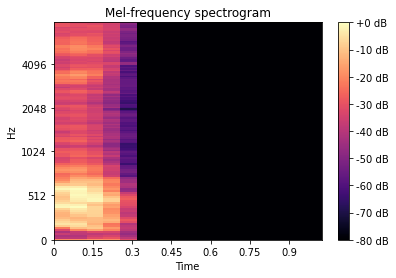

In [14]:
#librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length=512,n_mfcc=128)

#spec = librosa.stft(X[1500])
sr = 8000
S = librosa.feature.melspectrogram(X[1500], sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')





<ipython-input-5-9d8460ca3c5a>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)
<ipython-input-5-9d8460ca3c5a>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


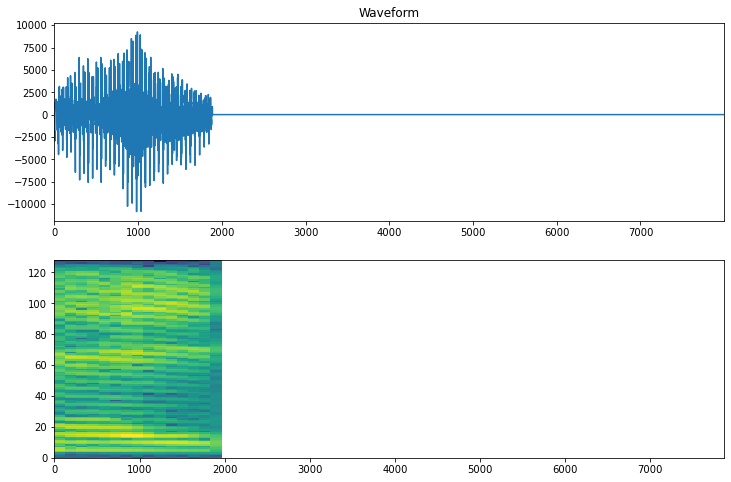

In [15]:
waveform = X[0]
spectrogram = get_spectrogram(waveform)


timescale = np.arange(waveform.shape[0])
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, max_size])
plot_spectrogram(spectrogram.numpy(), axes[1])


In [16]:

x_train_spec = []
for x in x_train:
    x_train_spec.append(get_spectrogram(x))
    
x_train_spec = np.array(x_train_spec)


x_val_spec = []
for x in x_val:
    x_val_spec.append(get_spectrogram(x))

x_val_spec = np.array(x_val_spec)

In [17]:

x_train_mel = []
for x in x_train:
    spec = librosa.feature.melspectrogram(y=x, sr=8000)
    x_train_mel.append(librosa.power_to_db(spec, ref=np.max))
    
x_train_mel = np.array(x_train_mel)


x_val_mel = []
for x in x_val:
    spec = librosa.feature.melspectrogram(y=x, sr=8000)
    x_val_mel.append(librosa.power_to_db(spec, ref=np.max))
    
x_val_mel = np.array(x_val_mel)


In [18]:
x_train_mfcc = []
for x in x_train:
    spec = librosa.feature.mfcc(y=x, sr=8000)
    x_train_mfcc.append(spec)
    
x_train_mfcc = np.array(x_train_mfcc)


x_val_mfcc = []
for x in x_val:
    spec = librosa.feature.mfcc(y=x, sr=8000)
    x_val_mfcc.append(spec)
    
x_val_mfcc = np.array(x_val_mfcc)

In [19]:
#for spectrogram, _ in spectrogram_ds.take(1):
#  input_shape = spectrogram.shape
#print('Input shape:', input_shape)

x_train_cur = x_train_mfcc
x_val_cur = x_val_mfcc
input_shape = x_train_cur.shape
num_labels = 10

print(input_shape)

#norm_layer = preprocessing.Normalization()
#norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=(*x_train_cur[0].shape, 1)),
    preprocessing.Resizing(32, 32), 
    #norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels),
])

model.summary()

(7200, 20, 16)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [21]:
EPOCHS = 25
history = model.fit(
    x_train_cur, 
    np.array(y_train),
    validation_data=(x_val_cur, np.array(y_val)),  
    epochs=EPOCHS
)# 75ms/st

Epoch 1/25
225/225 [==============================] - 5s 21ms/step - loss: 3.2130 - accuracy: 0.3606 - val_loss: 0.7517 - val_accuracy: 0.7400
Epoch 2/25
225/225 [==============================] - 4s 18ms/step - loss: 0.8445 - accuracy: 0.6958 - val_loss: 0.5850 - val_accuracy: 0.8092
Epoch 3/25
225/225 [==============================] - 4s 18ms/step - loss: 0.6361 - accuracy: 0.7696 - val_loss: 0.5067 - val_accuracy: 0.8308
Epoch 4/25
225/225 [==============================] - 4s 18ms/step - loss: 0.5623 - accuracy: 0.7948 - val_loss: 0.4668 - val_accuracy: 0.8408
Epoch 5/25
225/225 [==============================] - 4s 18ms/step - loss: 0.5042 - accuracy: 0.8277 - val_loss: 0.3945 - val_accuracy: 0.8712
Epoch 6/25
225/225 [==============================] - 4s 18ms/step - loss: 0.4343 - accuracy: 0.8494 - val_loss: 0.3862 - val_accuracy: 0.8721
Epoch 7/25
225/225 [==============================] - 4s 18ms/step - loss: 0.3879 - accuracy: 0.8609 - val_loss: 0.3723 - val_accuracy: 0.8763

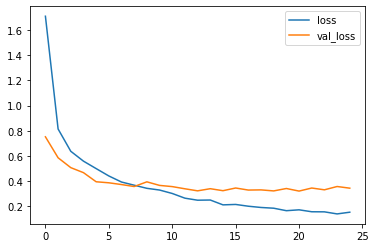

In [22]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [76]:
import pyaudio
import wave

chunk = 1000  # Record in chunks of 1024 samples
sample_format = pyaudio.paInt16  # 16 bits per sample
channels = 1
fs = 8000  # Record at 44100 samples per second
seconds = 2
filename = "output.wav"

p = pyaudio.PyAudio()  # Create an interface to PortAudio

print('Recording')

stream = p.open(format=sample_format,
                channels=channels,
                rate=fs,
                frames_per_buffer=chunk,
                input=True)

frames = []  # Initialize array to store frames

# Store data in chunks for 3 seconds
for i in range(0, int(fs / chunk * seconds)):
    data = stream.read(chunk)
    frames.append(data)

# Stop and close the stream 
stream.stop_stream()
stream.close()
# Terminate the PortAudio interface
p.terminate()

print('Finished recording')

# Save the recorded data as a WAV file
wf = wave.open(filename, 'wb')
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(sample_format))
wf.setframerate(fs)
wf.writeframes(b''.join(frames))
wf.close()

Recording
Finished recording


(16000,)
(2940,)
7998 2940
(20, 16)


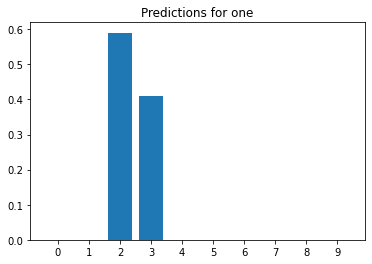

In [77]:
labels = [str(i) for i in range(10)]
rate, data = wavfile.read("output.wav")
print(data.shape)

trimmed_data = trim_silence(data.astype(np.float16))



print(trimmed_data.shape)

print(max_size, trimmed_data.shape[0])

my_X = np.pad(trimmed_data, (0, max_size - trimmed_data.shape[0]))

my_spec = librosa.feature.mfcc(y=my_X, sr=8000)
print(my_spec.shape)


'''
y_pred = model.predict(my_spec.reshape(1, *my_spec.shape, 1))
predicted_categories = tf.argmax(y_pred, axis=1)
print(predicted_categories)
'''

prediction = model(my_spec.reshape(1,*my_spec.shape, 1))
plt.bar(labels, tf.nn.softmax(prediction[0]))
plt.title(f'Predictions for one')
plt.show()


In [67]:
i = ipd.Audio(trimmed_data, rate=8000)
i

In [26]:

y_pred = model.predict(np.array(x_test).reshape(len(x_test), 30, 30, 1))

predicted_categories = tf.argmax(y_pred, axis=1)

true_categories = y_test

cm = confusion_matrix(true_categories,predicted_categories)
plot_confusion_matrix(cm, classes, normalize=False)

ValueError: cannot reshape array of size 19195200 into shape (2400,30,30,1)